# Explore here

In [1]:
#Importamos Librerias Necesarias
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import *
from imblearn.metrics import specificity_score

# EDA

In [2]:
# Cargamos el dataset
df = pd.read_csv('../data/raw/diabetes.csv')

# Visualizamos los datos
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
# Visualizamos las Estadísticas descriptivas
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [ ]:
# Visualizamos la informacion de la dfsets
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# Verificamos si existen datos únicos
n_unicos = df.nunique()
n_unicos

Pregnancies                  17
Glucose                     136
BloodPressure                47
SkinThickness                51
Insulin                     186
BMI                         248
DiabetesPedigreeFunction    517
Age                          52
Outcome                       2
dtype: int64

In [6]:
# Revisamos que no tengamos datos duplicados
df.duplicated().sum()

0

In [7]:
# Verificamos los datos nulos o faltantes
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

<Axes: >

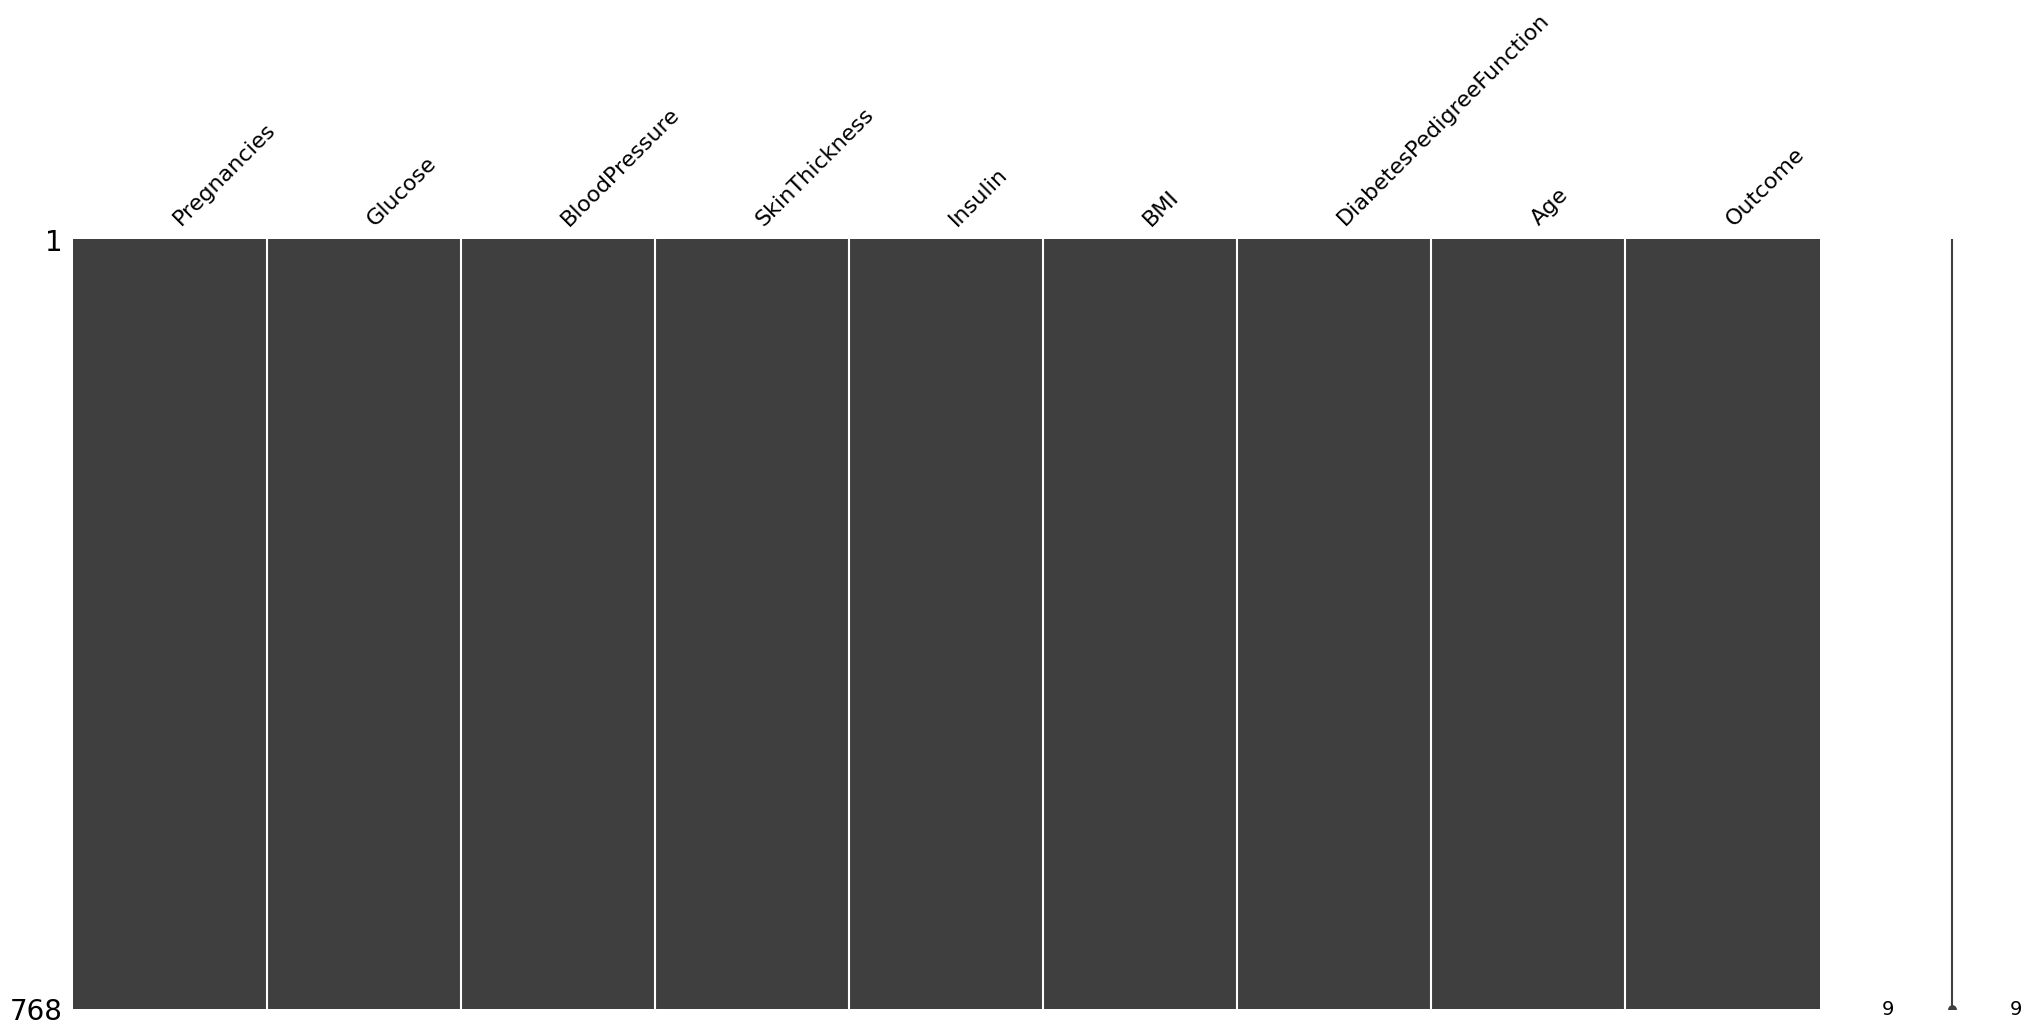

In [8]:
msno.matrix(df)

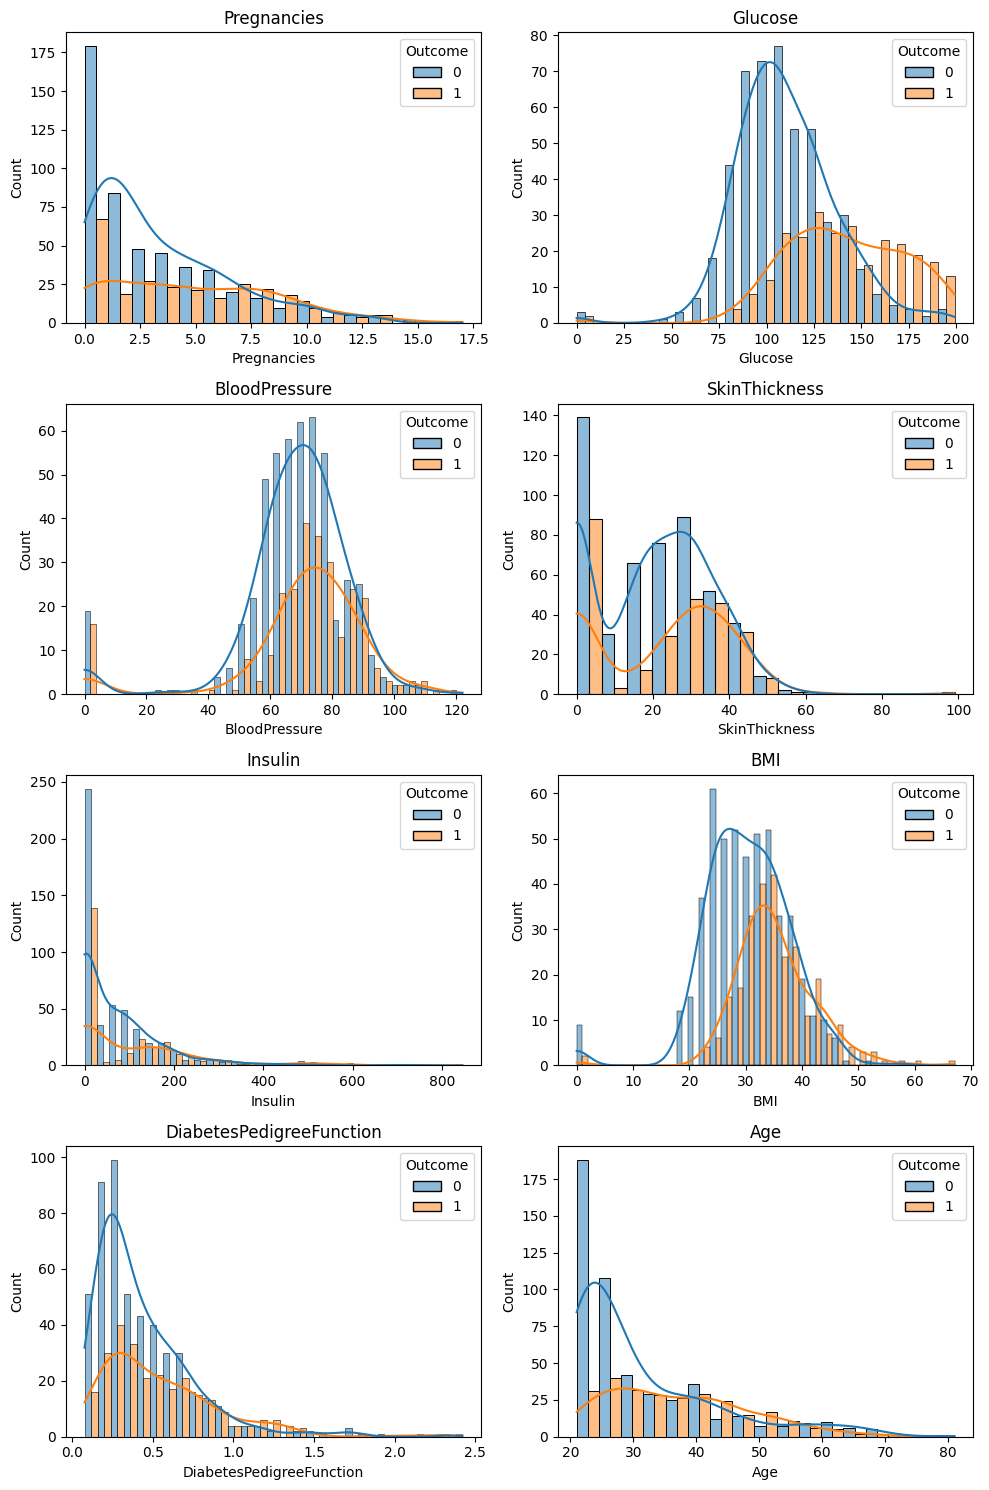

In [9]:
# Seleccinamos las columnas a graficar
columnas = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Creamos hisplot para cada una
fig, axes = plt.subplots(4, 2, figsize=(10, 15))
axes = axes.flatten()  # Convertimos los ejes en una lista plana para iterar

# Iteramos por cada columna del dataframe
for i, columna in enumerate(columnas):
    sns.histplot(ax=axes[i], x=columna, data=df, hue='Outcome', kde=True, multiple='dodge')  
    axes[i].set_title(columna)

# Para mostrar el gráfico
plt.tight_layout()
plt.show()

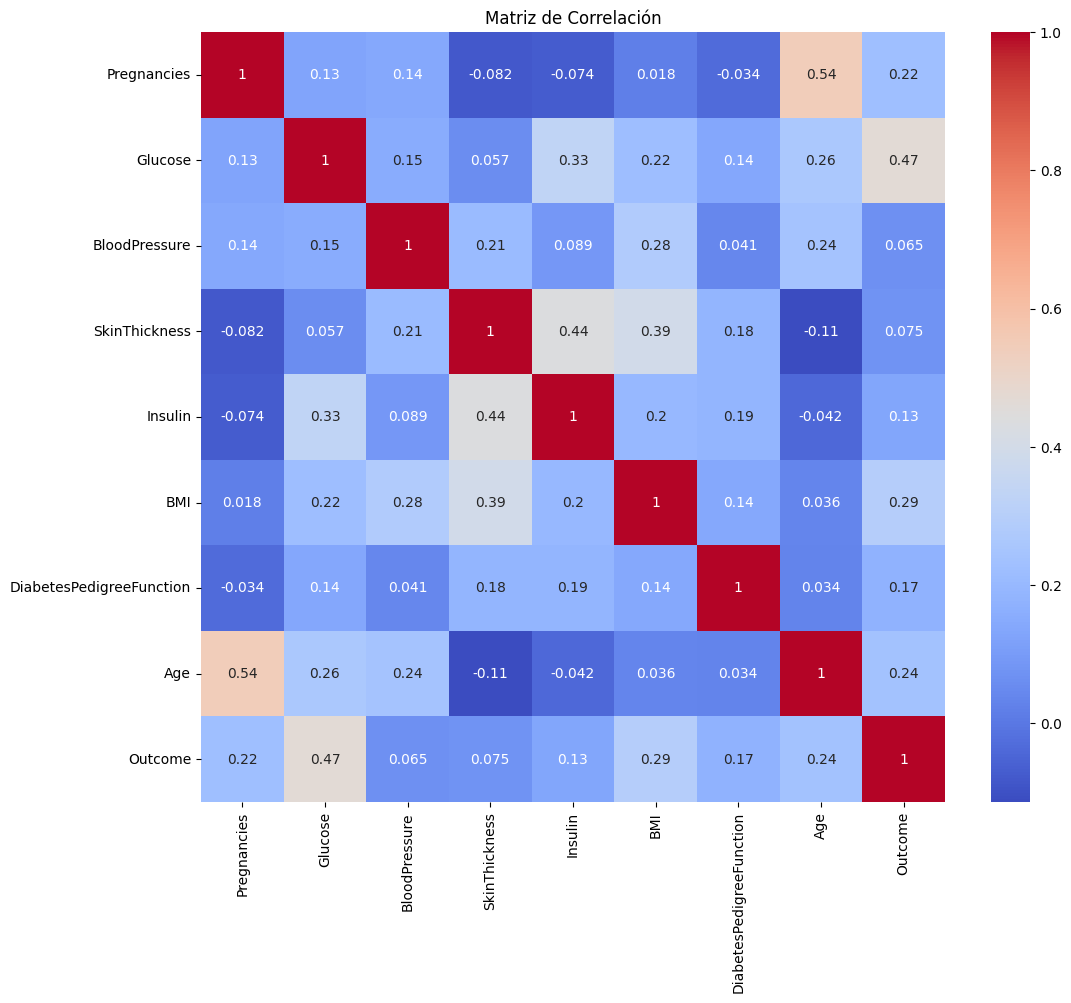

In [10]:
# Matriz de correlación
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

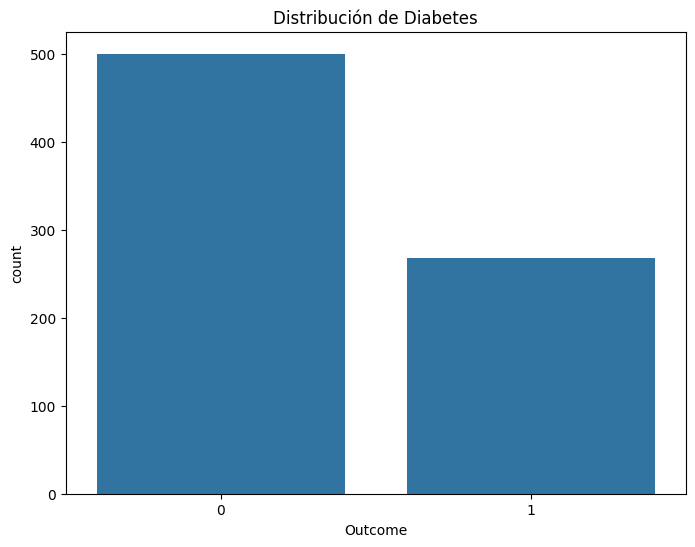

In [11]:
# Distribución de la variable objetivo
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df)
plt.title('Distribución de Diabetes')
plt.show()

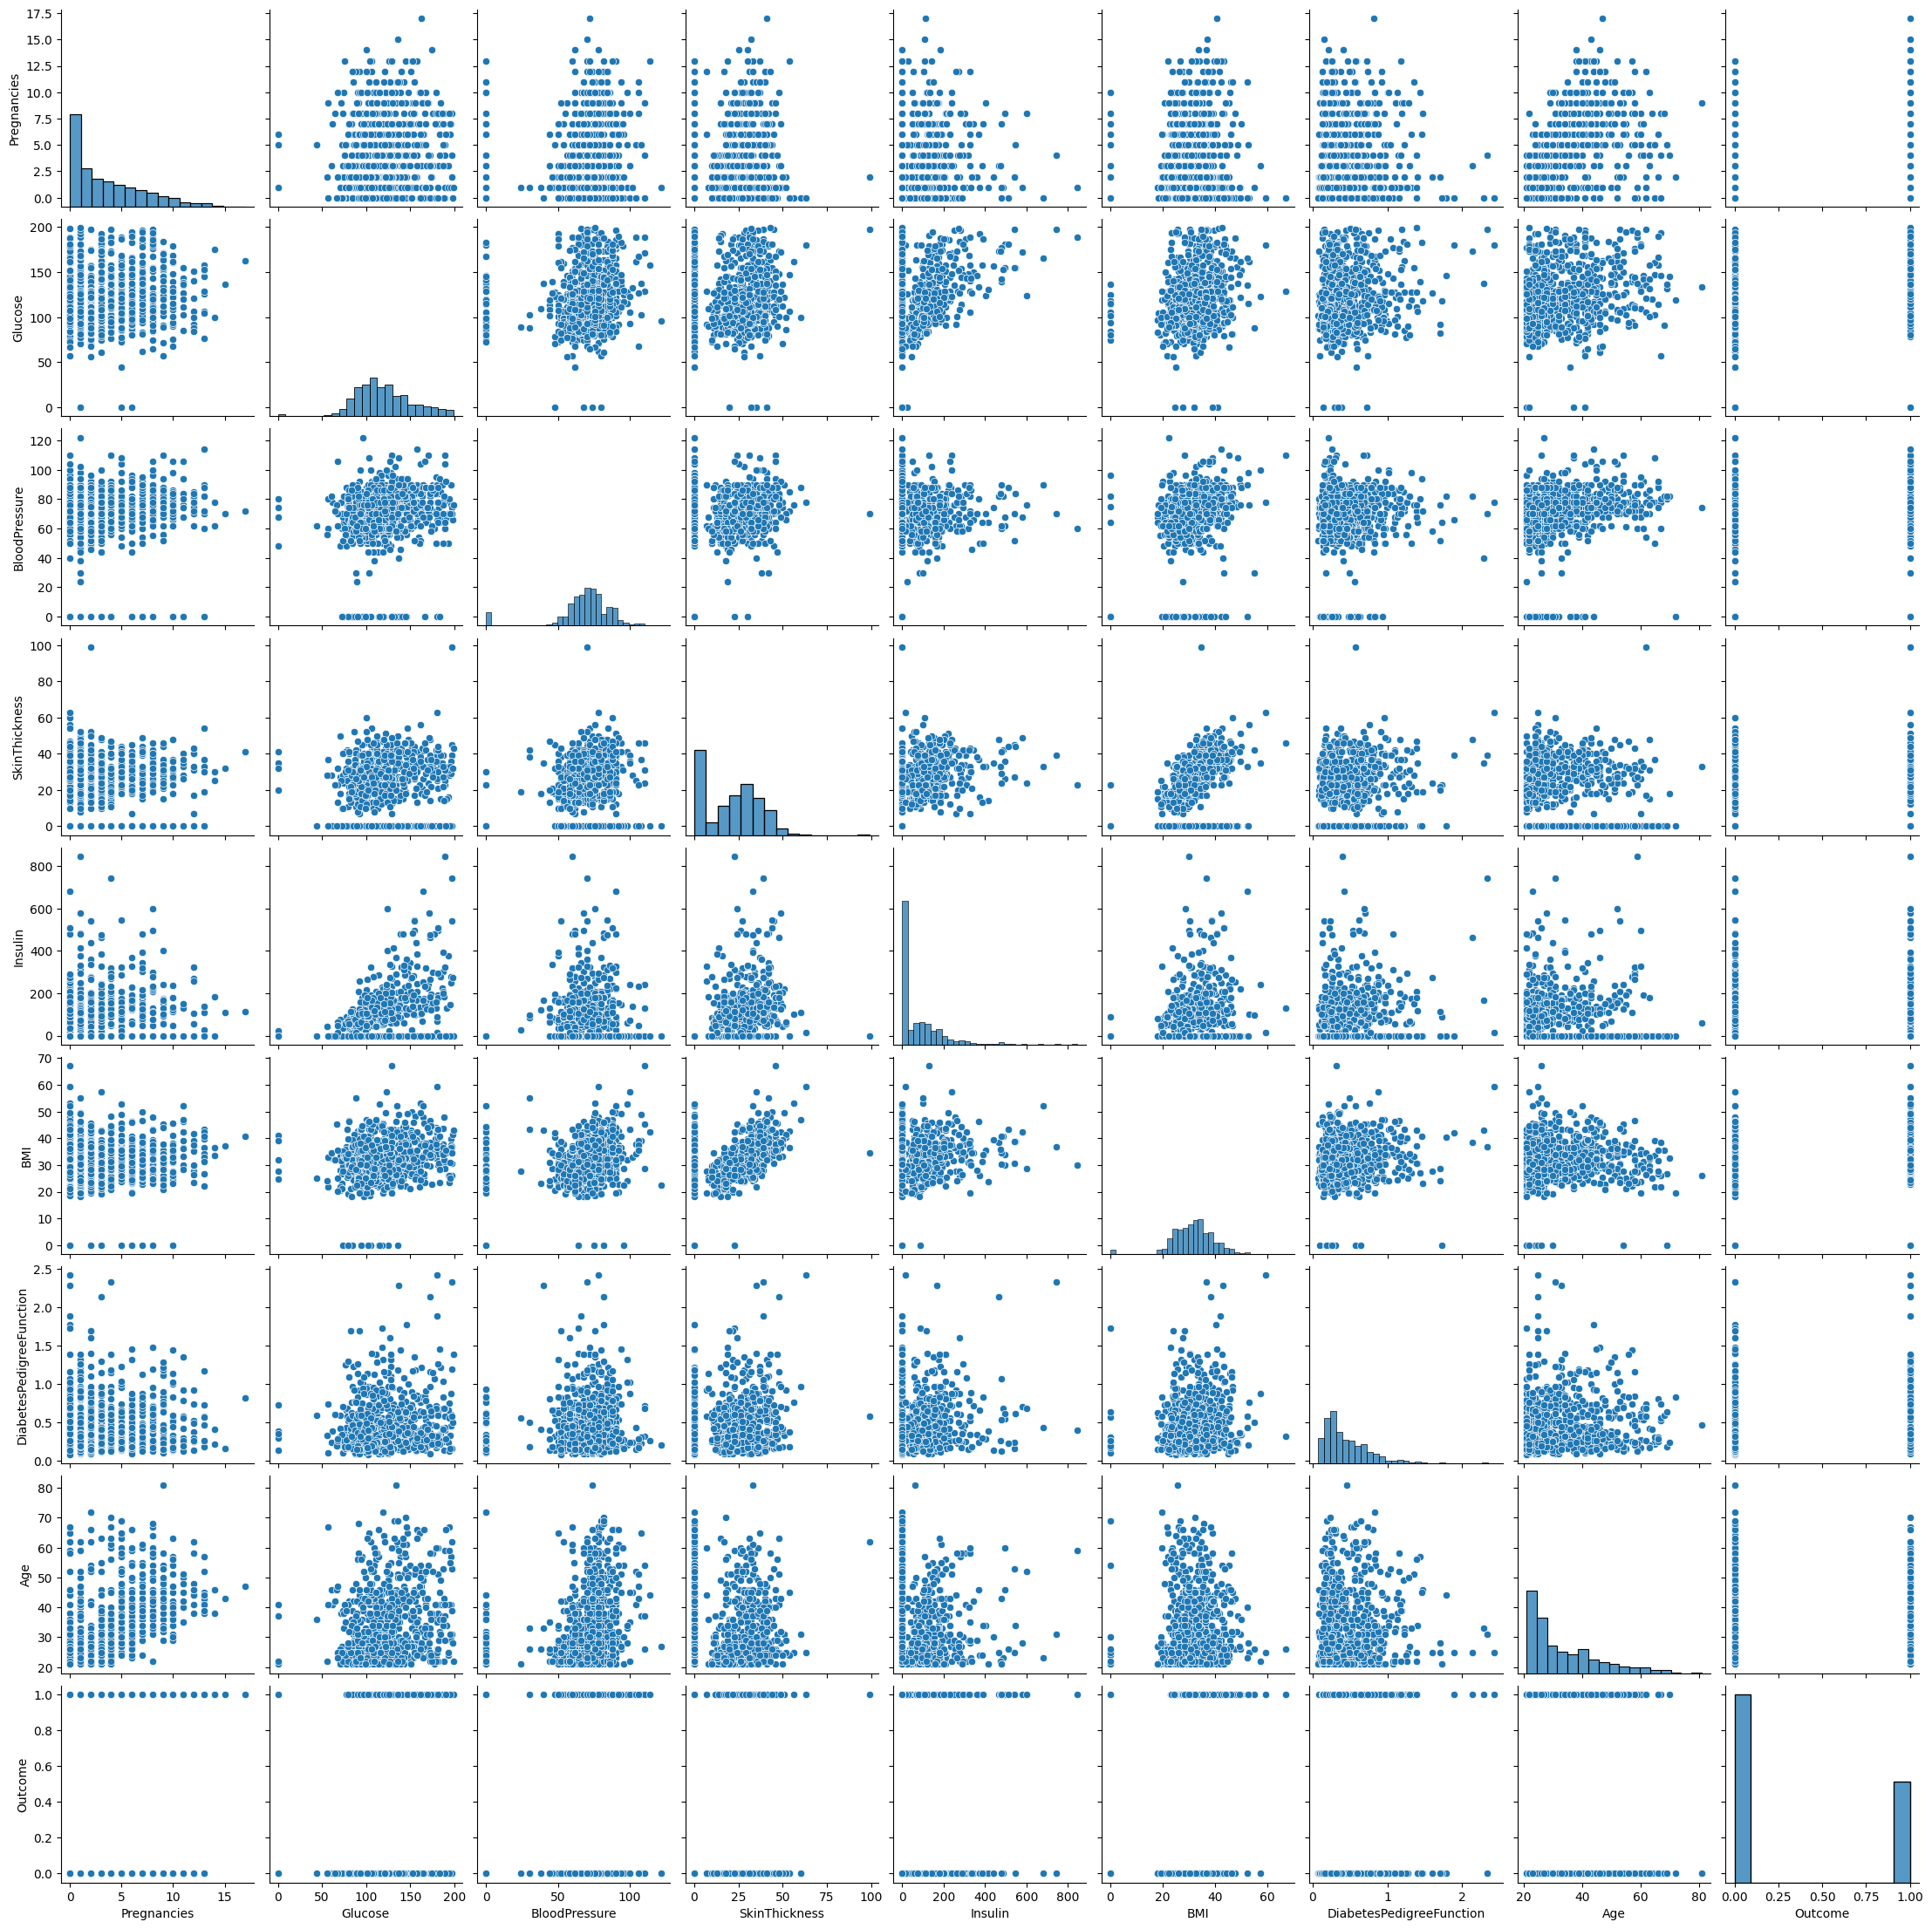

In [12]:
# Realizamos un pairplot
sns.pairplot(df)

In [13]:
df['Outcome']=df['Outcome'].map({1:0, 0:1})

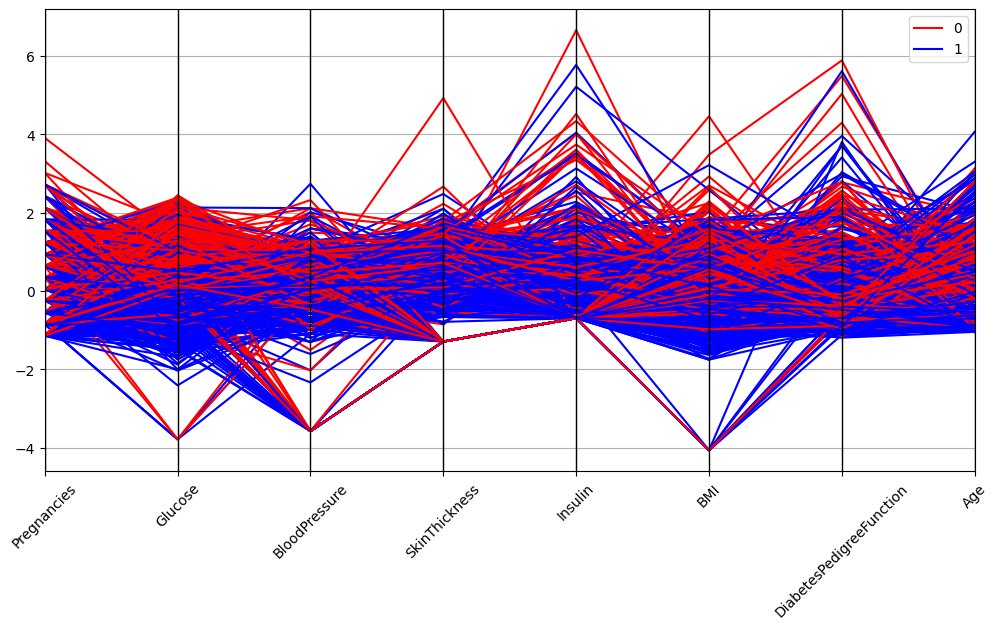

In [15]:
df_sc = pd.DataFrame(StandardScaler().fit_transform(df.drop(['Outcome'], axis=1)), columns=df.columns[:-1])
df_sc['Outcome'] = df.Outcome
plt.figure(figsize=(12, 6))
pd.plotting.parallel_coordinates(df_sc, 'Outcome', color=['red', 'blue'])
plt.xticks(rotation=45)
plt.show()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['Outcome'],axis=1), df['Outcome'], test_size=0.2, random_state=42)

In [42]:
# Creamos el árbol de decisión
modelo_tree = DecisionTreeClassifier(
    max_depth=20,                   # Mayor profundidad controlada
    min_samples_leaf=15,            # Menos muestras por hoja
    ccp_alpha=0.01,                 # Poda menos agresiva
    max_features='sqrt',            # Mantener para reducir varianza
    class_weight='balanced',        # Compensar desbalance de clases
    random_state=42                 # Reproducibilidad
).fit(X_train, y_train)

# Aplicamos al árbol los datos de entrenamiento y de test

train_pred_simple = modelo_tree.predict(X_train)
test_pred_simple = modelo_tree.predict(X_test)

In [43]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall, train_specificity],[test_accuracy, test_f1, test_auc, test_precision, test_recall, test_specificity],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall, diff_specificity]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall', 'Specificity'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [44]:
print(get_metrics(y_train, y_test, train_pred_simple, test_pred_simple))

            Accuracy        F1       AUC  Precision    Recall  Specificity
Train       0.695440  0.720478  0.737118   0.899254  0.600998     0.873239
Test        0.655844  0.674847  0.695960   0.859375  0.555556     0.836364
Diferencia  0.039596  0.045632  0.041159   0.039879  0.045442     0.036876


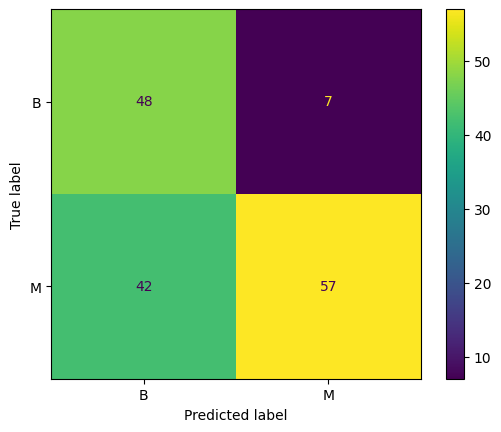

In [38]:
cm = confusion_matrix(y_test, test_pred_simple)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['B', 'M'])
disp.plot()

In [39]:
text_representation = export_text(modelo_tree, feature_names=list(X_train.columns))
print(text_representation)

|--- Pregnancies <= 6.50
|   |--- DiabetesPedigreeFunction <= 0.32
|   |   |--- Glucose <= 120.50
|   |   |   |--- class: 1
|   |   |--- Glucose >  120.50
|   |   |   |--- class: 0
|   |--- DiabetesPedigreeFunction >  0.32
|   |   |--- Glucose <= 114.50
|   |   |   |--- class: 1
|   |   |--- Glucose >  114.50
|   |   |   |--- class: 0
|--- Pregnancies >  6.50
|   |--- class: 0



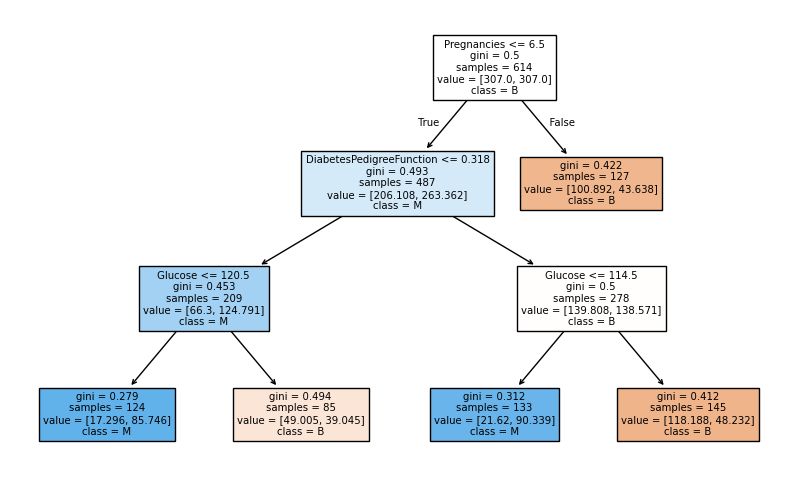

In [40]:
plt.figure(figsize=(10, 6))
plot_tree(modelo_tree, feature_names=X_train.columns, class_names=['B','M'], filled=True)
plt.show()